In [1]:
# load packages
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import acf, ccf
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sys
from datetime import datetime
import numpy as np
from Swing import Swing
from Swing.util.Evaluator import Evaluator
import numpy as np

import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

sys.path.append("../pipelines")
import Pipelines as tdw

def get_experiment_list(filename):
    # load files
    timecourse = pd.read_csv(filename, sep="\t")
    # divide into list of dataframes
    experiments = []
    for i in range(0,85,21):
        experiments.append(timecourse.ix[i:i+20])
    #reformat
    for idx,exp in enumerate(experiments):
        exp = exp.set_index('Time')
        experiments[idx]=exp
    return(experiments)

In [2]:
data_folder = "/projects/p20519/roller_output/optimizing_window_size/RandomForest/insilico_size10_1/"

output_path = "/home/jjw036/Roller/insilico_size10_1"

current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
save_path = ('./window_size_selection_swing_results.pickle')

data_folder = "../output/insilico_size10_1"
file_path = "../data/dream4/insilico_size10_1_timeseries.tsv"
run_params = {'data_folder': data_folder,
              'file_path':file_path,
              'td_window':10,
              'min_lag':1,
              'max_lag':3,
              'n_trees':10,
              'permutation_n':10,
              'lag_method':'mean_mean',
              'calc_mse':False,
              'bootstrap_n':100,
              'n_trials':1,
              'run_time':current_time,
              'sort_by':'adj',
              'iterating_param':'td_window',
              }

try:
    tdr = pd.read_pickle(save_path)
except:
    roc,pr, tdr = tdw.get_td_stats(**run_params)
    pd.to_pickle(tdr, save_path)

['Time', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']
Running permutation on window 3...
Running permutation on window 4...
Running permutation on window 5...
Running permutation on window 6...
Running permutation on window 7...
Running permutation on window 8...
Running permutation on window 9...
Running permutation on window 10...
Running permutation on window 11...
Compiling all model edges...
[DONE]
Lumping edges...
[DONE]

/Users/jjw036/Roller/Swing/Swing.py:564: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  current_df.sort(['adj_imp'], ascending=False, inplace=True)
/Users/jjw036/Roller/Swing/Swing.py:692: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  sort_df.sort(sort_field, ascending=False, inplace=True)



Calculating adj edge importance...
[DONE]
90
Scoring model...
[DONE]
0.817777777778
0.470187012263


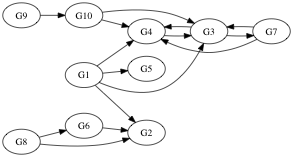

In [3]:
#list of nodes = G1..G10
nodes = ['G'+str(x) for x in range(1,11)]
#convert edge list to list of tuples
edges = pd.read_csv("../data/dream4/insilico_size10_1_goldstandard.tsv",sep="\t",header=None)
edges = edges[edges[2] > 0]
edges=edges[edges.columns[0:2]]
edges = [tuple(x) for x in edges.values]
G = nx.DiGraph()
G.graph['rankdir'] = 'LR'
G.graph['dpi'] = 50


G.add_nodes_from(nodes)
G.add_edges_from(edges)
#examples of other kinds of drawing
#G.add_node(0, color='red', style='filled', fillcolor='pink')
#G.add_node(1, shape='square')
#G.add_node(3, style='filled', fillcolor='#00ffff')
#G.add_edge(0, 1, color='red', style='dashed')
#G.add_edge(3, 3, label='a')
draw(G)

In [4]:
experiments=get_experiment_list(file_path)

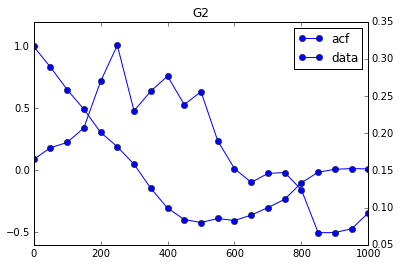

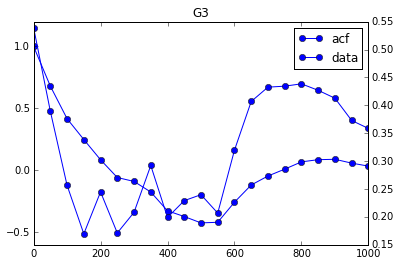

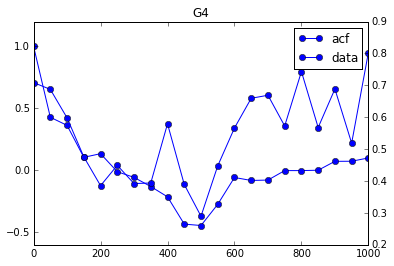

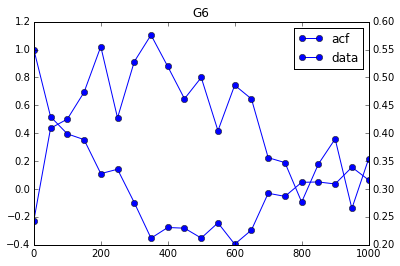

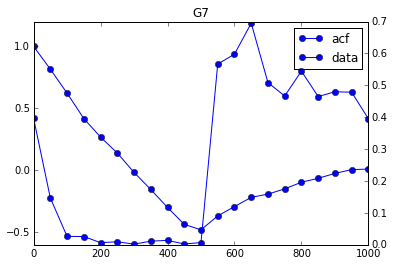

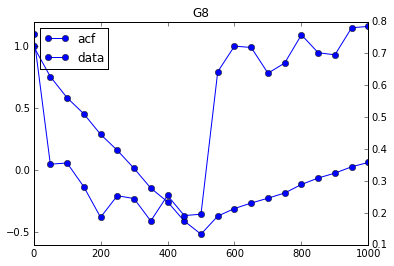

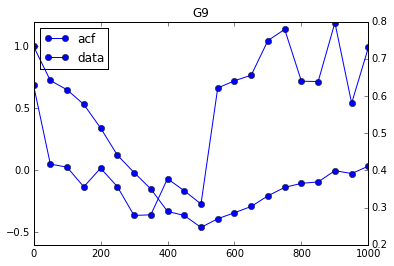

In [5]:
ce = 3
for gene in tdr.gene_list:
    auto = acf(experiments[ce][gene])
    x = stats.linregress(tdr.time_vec[:10], auto[:10])
    p_val = x[3]*len(tdr.gene_list)
    if p_val < 0.05:
        fig, ax1 = plt.subplots()
        ln1= ax1.plot(tdr.time_vec, auto, 'o-', label='acf')
        ax2 = ax1.twinx()
        ln2 = ax2.plot(tdr.time_vec, (experiments[ce][gene]), 'o-', c='r', label='data')
        lns = ln1+ln2
        labs = [l.get_label() for l in lns]
        ax2.legend(lns, labs, loc='best')
        plt.title(gene)

# This may represent the genes that should be used as child nodes in the regression for THIS experiment

In [6]:
current_gold_standard = file_path.replace("timeseries.tsv","goldstandard.tsv")
evaluator = Evaluator(current_gold_standard, '\t')
true_edges = evaluator.gs_flat.tolist()
print(true_edges)

[('G1', 'G2'), ('G1', 'G3'), ('G1', 'G4'), ('G1', 'G5'), ('G3', 'G4'), ('G3', 'G7'), ('G4', 'G3'), ('G6', 'G2'), ('G7', 'G3'), ('G7', 'G4'), ('G8', 'G2'), ('G8', 'G6'), ('G9', 'G10'), ('G10', 'G3'), ('G10', 'G4')]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
  Parent Child    Slope     Pval
0     G1    G1 -0.00096 28.14543
1     G1    G2  0.00067  2.10543
2     G1    G3 -0.00038 45.25526
3     G1    G4 -0.00037 50.59570
4     G1    G5 -0.00040 54.29537


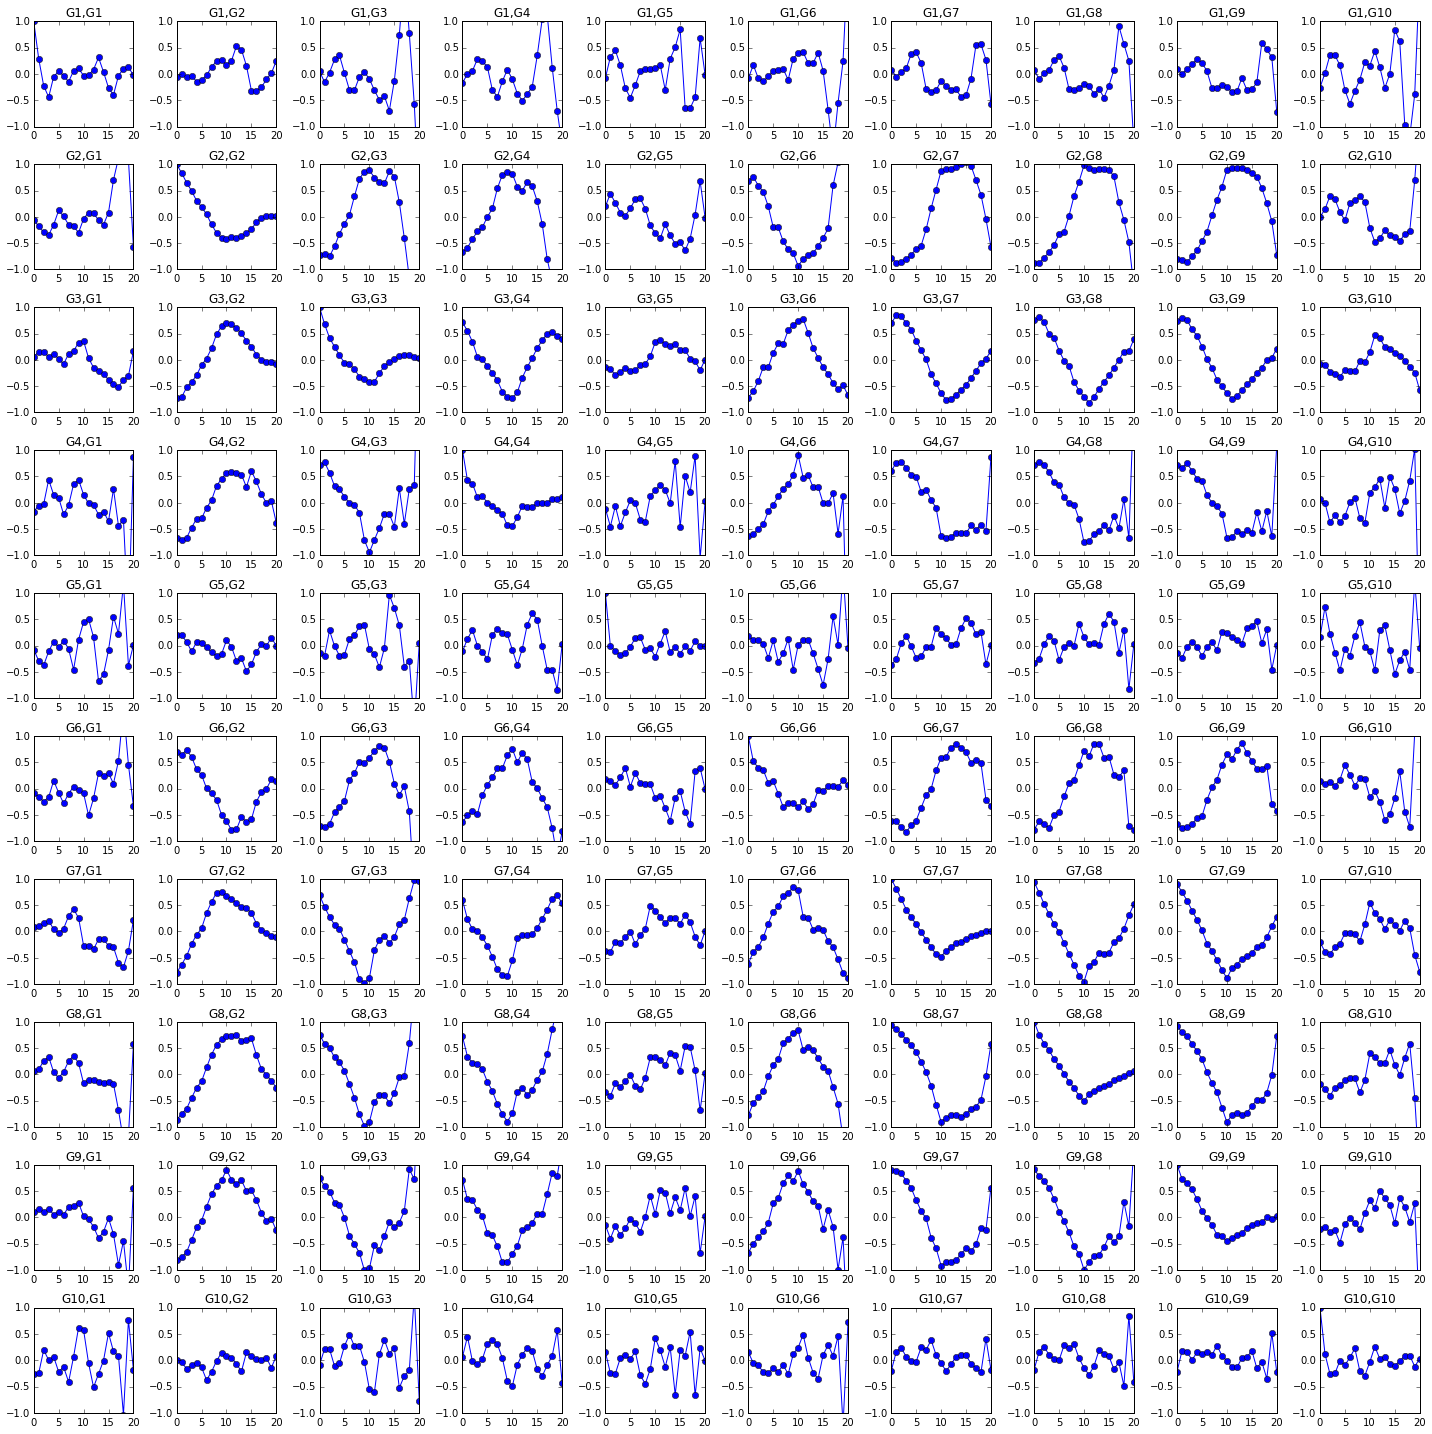

In [7]:
f = plt.figure(figsize=(20,20))
ii = 1
parent = []
child = []
slope = []
p_value = []
for gene1 in tdr.gene_list:
    for gene2 in tdr.gene_list:
        current_ax = f.add_subplot(len(tdr.gene_list),len(tdr.gene_list) , ii)
        if ((gene1, gene2) in true_edges):
            color = 'b'
        elif (((gene2, gene1) in true_edges)):
            color = 'r'
        else:
            color = 'k'
        unbiased = True
        if (gene1 == gene2):
            # Not clear why this is the case by statsmodels uses unbiased=False for acf
            # unbiased = False for ccf yields the same results as acf
            unbiased = False
        parent.append(gene1)
        child.append(gene2)
        ccf_results = ccf(experiments[ce][gene1], experiments[ce][gene2], unbiased=unbiased)
        x = stats.linregress(tdr.time_vec[:10], ccf_results[:10])
        slope.append(x.slope)
        p_value.append(x.pvalue*(len(tdr.gene_list)**2))
        current_ax.plot(ccf_results, 'o-', c=color)
        current_ax.set_title(gene1+','+gene2)
        current_ax.set_ylim([-1, 1])
        print(ii)
        ii+=1
plt.tight_layout()
df = pd.DataFrame([parent, child, slope, p_value], index=['Parent', 'Child', 'Slope', 'Pval']).T
print(df.head())

In [8]:
# This might be the list of edges that should even be considered
df[(df['Pval']<0.05) &(df['Parent']!=df['Child'])]
df['Abs_slope'] = np.abs(df['Slope'])
df.sort(columns='Abs_slope', inplace=True, ascending=False)
df

/Users/jjw036/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Parent,Child,Slope,Pval,Abs_slope
67,G7,G8,-0.00390,0.00000,0.00390
12,G2,G3,0.00390,0.00036,0.00390
82,G9,G3,-0.00386,0.00001,0.00386
72,G8,G3,-0.00381,0.00003,0.00381
87,G9,G8,-0.00375,0.00000,0.00375
62,G7,G3,-0.00372,0.00000,0.00372
81,G9,G2,0.00372,0.00000,0.00372
68,G7,G9,-0.00371,0.00000,0.00371
61,G7,G2,0.00368,0.00000,0.00368
71,G8,G2,0.00364,0.00000,0.00364


### Are cross-correlation and moving pearson the same?
If formulated properly, they appear to be the same. See test example below.

In [9]:
a = np.array([1,3,2,6])
ai = a-a.mean()
(np.correlate(ai,ai, 'full')[len(a)-1:]/np.array([4,3,2,1]))/np.std(a)**2

array([ 1.        , -0.28571429,  0.28571429, -1.71428571])

In [10]:
ccf(a,a)

array([ 1.        , -0.28571429,  0.28571429, -1.71428571])

In [11]:
stats.pearsonr([1,3,2,6], [1,3,2,6])

(1.0, 0.0)

In [12]:
stats.pearsonr([3,2,6], [1,3,2])

(-0.24019223070763066, 0.84557904168873266)

In [13]:
stats.pearsonr([2,6], [1,3])

(1.0, 0.0)

In [14]:
a_trunc = np.array([3,2,6])
a_shift = np.array([1,3,2])
ccov = np.mean((a_trunc-a.mean())*(a_shift-a.mean()))/(np.std(a)**2)
ccov

-0.2857142857142857

In [15]:
a_trunc = np.array([2,6])
a_shift = np.array([1,3])
ccov = np.mean((a_trunc-a.mean())*(a_shift-a.mean()))/(np.std(a)**2)
ccov

0.2857142857142857

### Let's try on real data

In [16]:
# How does pearson correlation compare to cross correlation
g1 = 'G1'
g2 = 'G2'
######################################################################################################################
#NOTE: If you don't take the values from the pd dataframe it messes things up
######################################################################################################################
g1_data = experiments[1][g1].values
g2_data = experiments[1][g2].values
ccf_results = ccf(g1_data, g2_data)

In [17]:
vals = []
for ii in range(len(g1_data)-1):
    trunc_g1 = g1_data[ii:,]
    if ii == 0:
        shift_g2 = g2_data[:]
    else:
        shift_g2 = g2_data[:-ii,]
    ccov = np.mean((trunc_g1-g1_data.mean())*(shift_g2-g2_data.mean()))
    vals.append(ccov/(np.std(g1_data)*np.std(g2_data)))


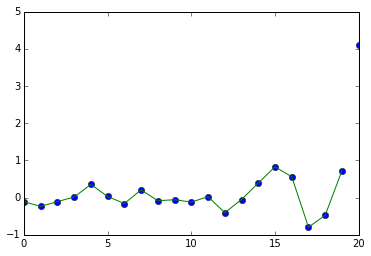

In [18]:
plt.figure()
plt.plot(ccf_results, 'o')
plt.plot(vals)

### Now let's look at some real lags and see what is going on

/Users/jjw036/anaconda/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


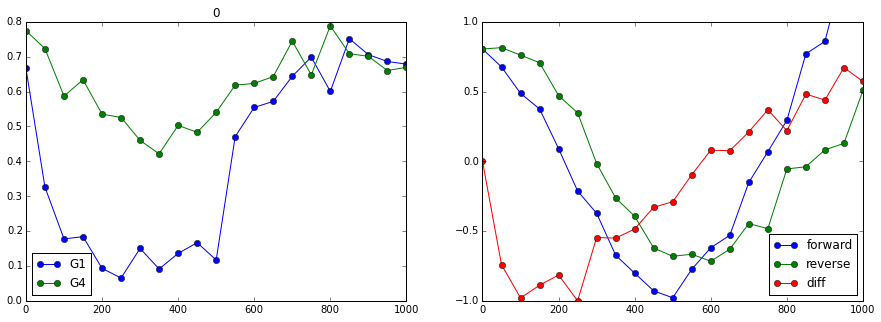

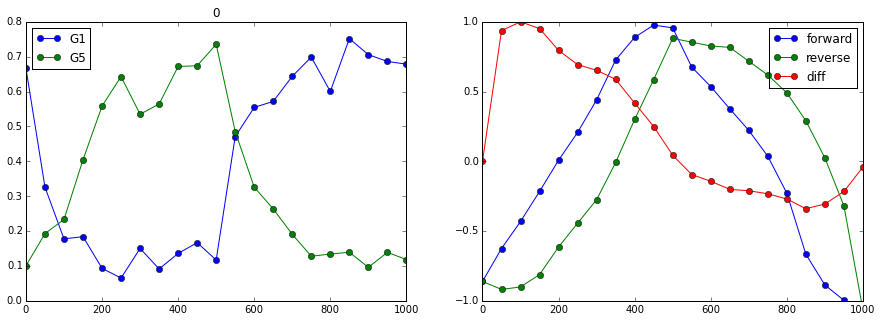

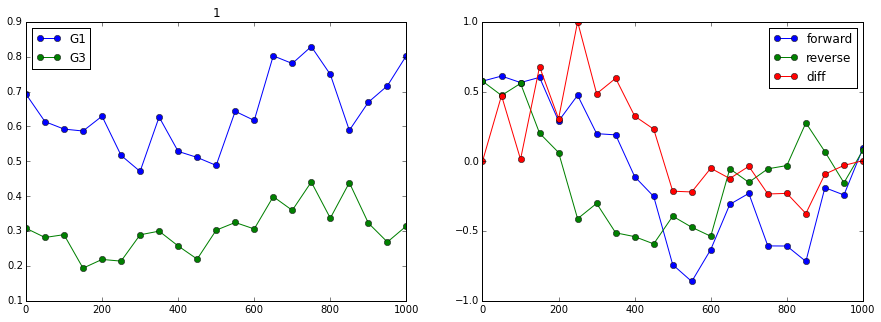

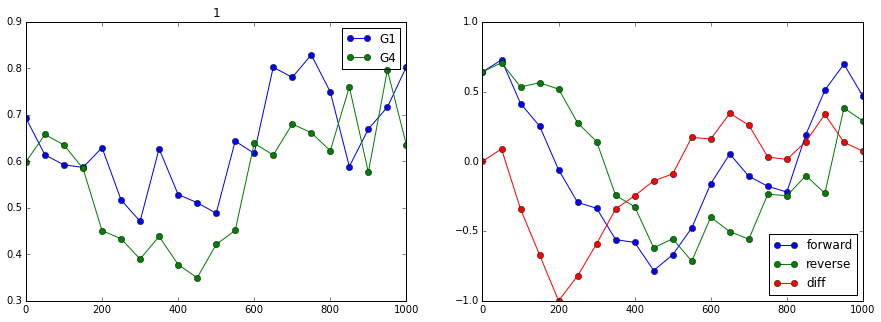

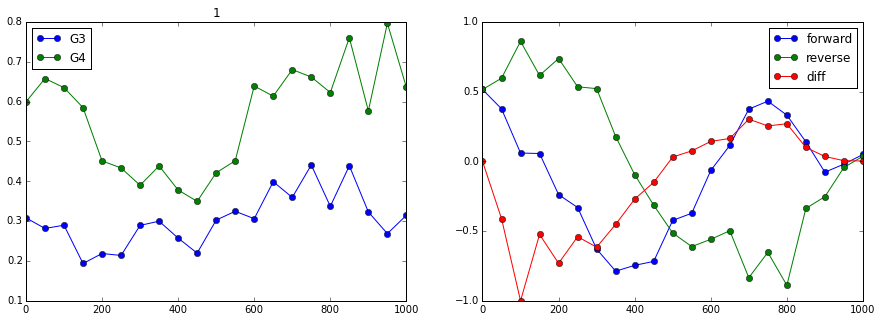

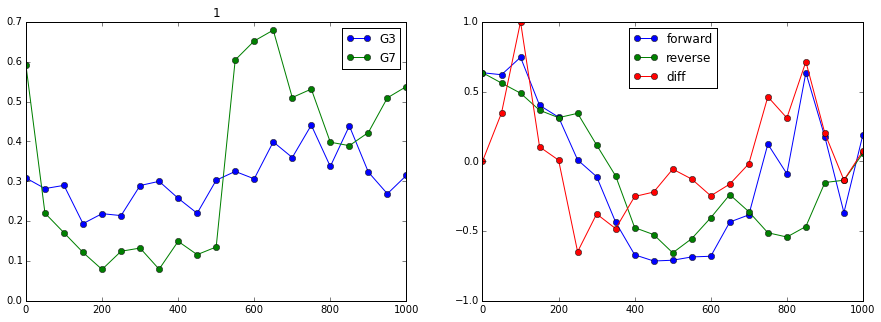

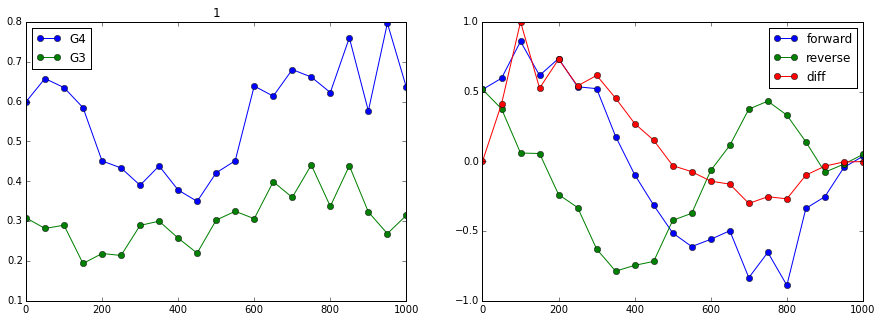

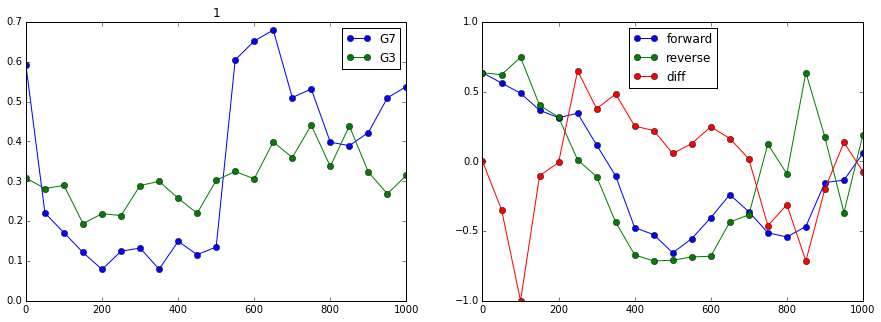

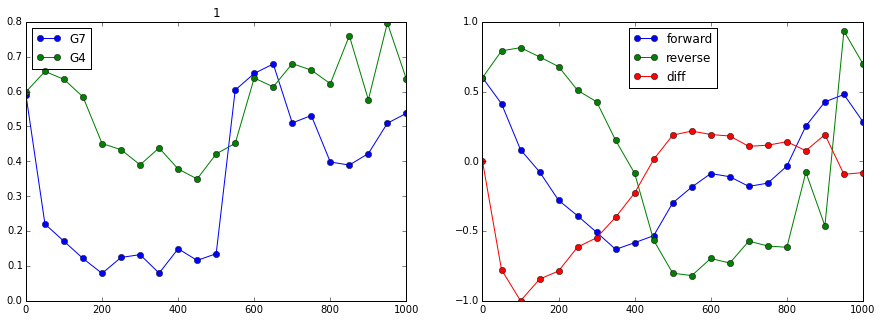

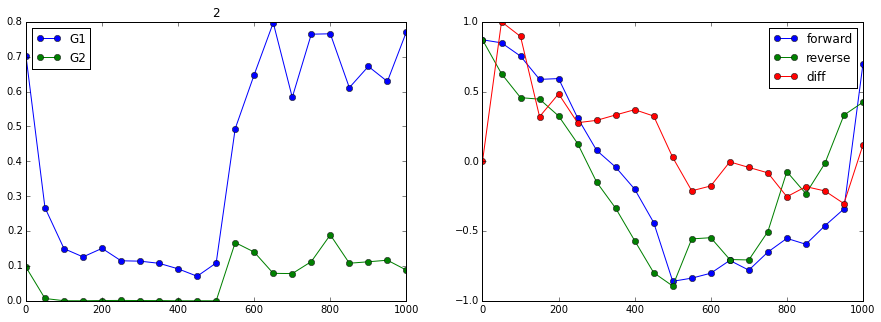

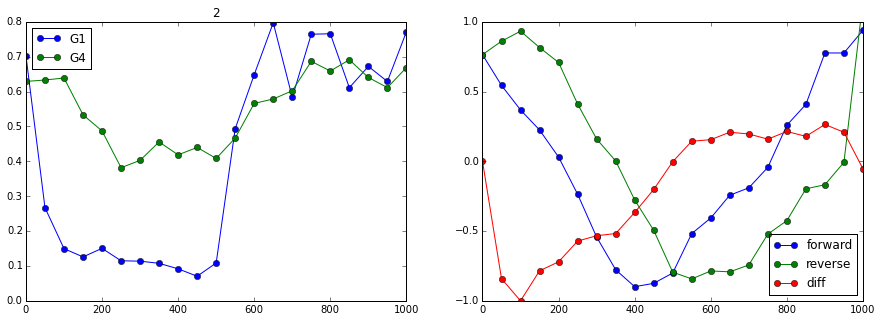

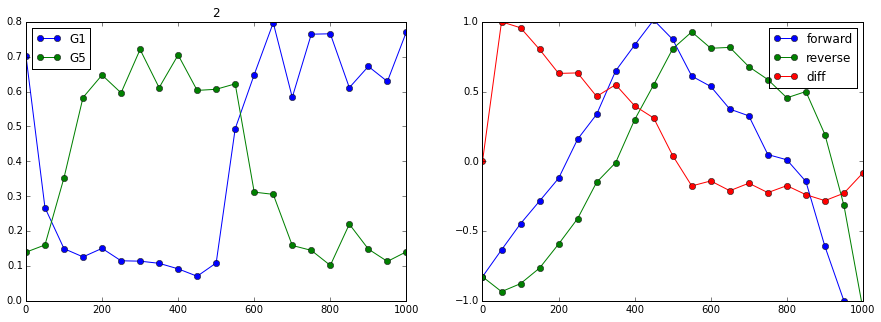

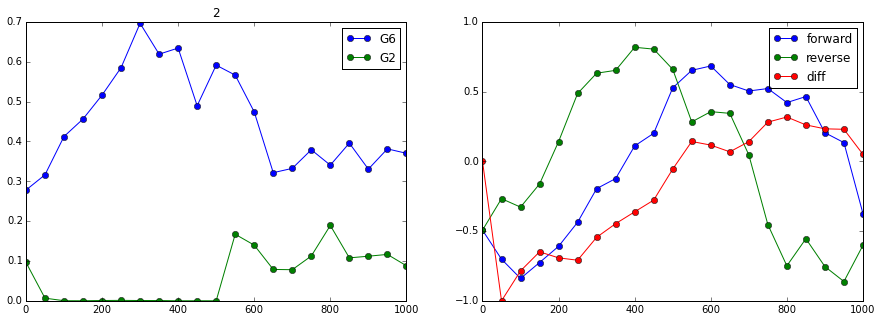

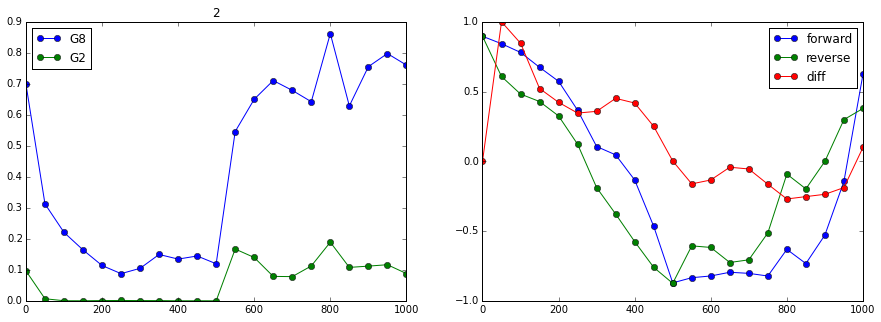

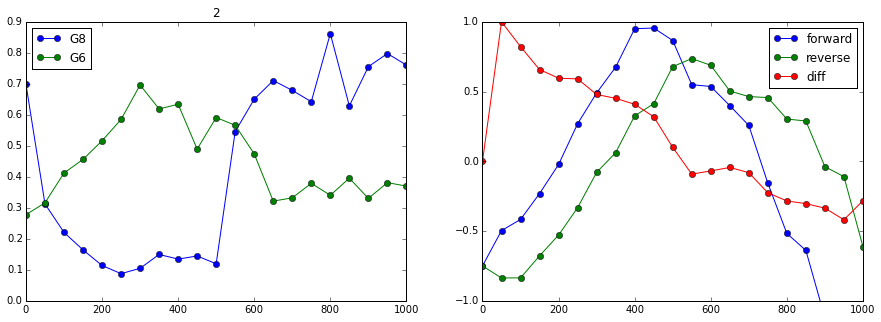

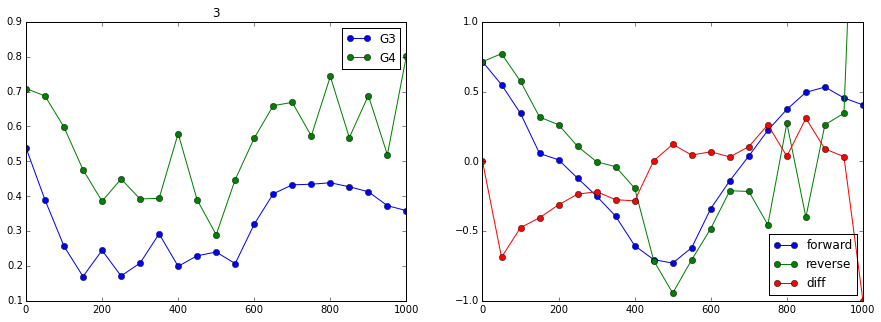

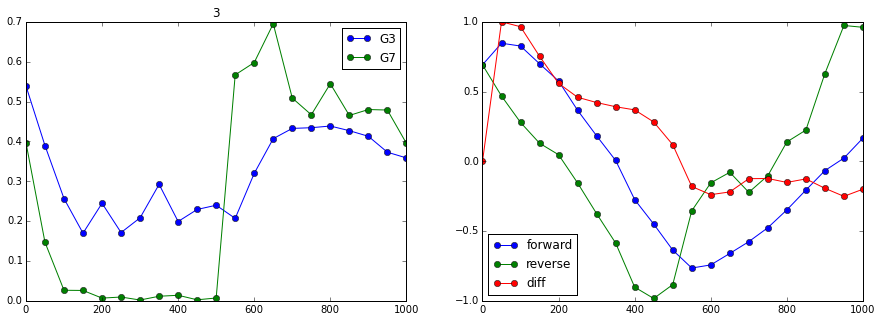

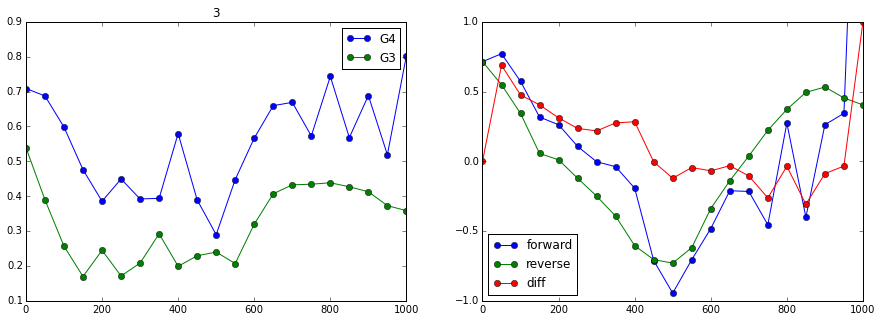

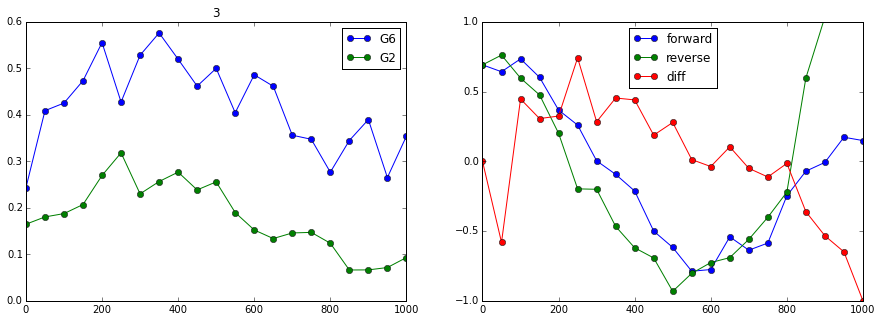

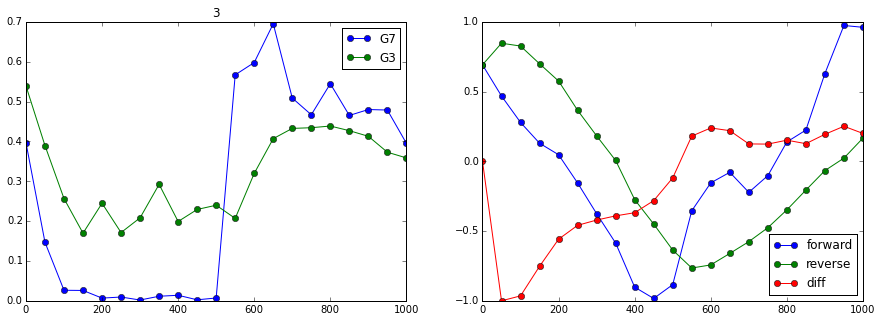

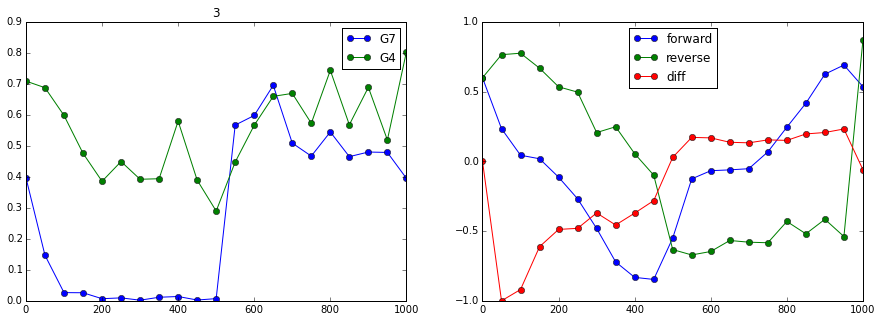

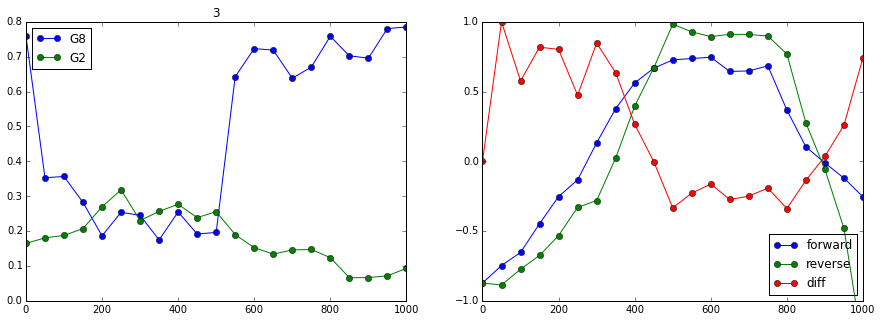

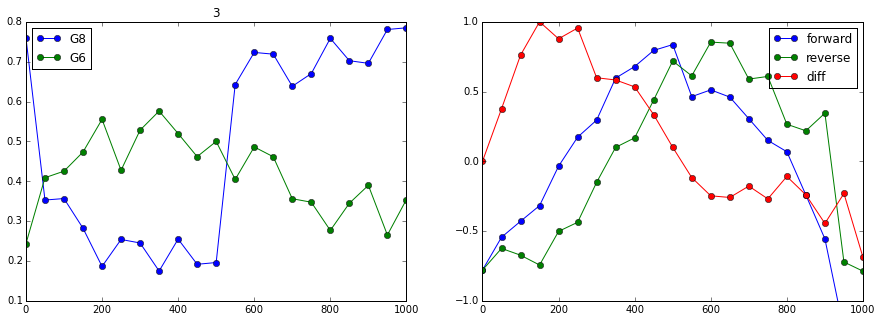

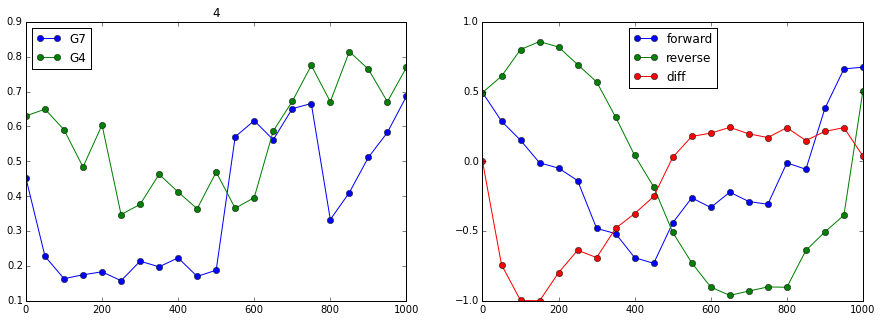

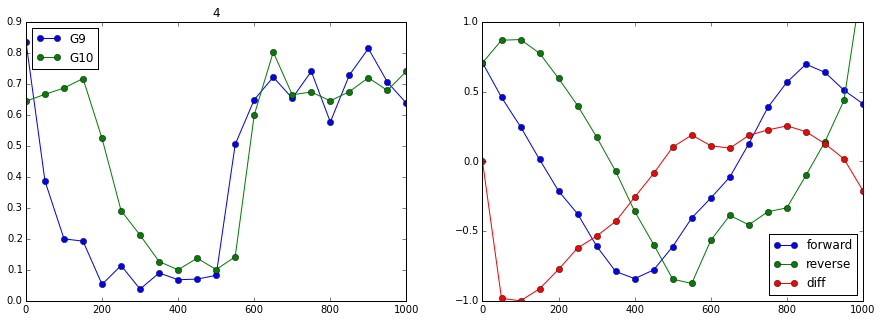

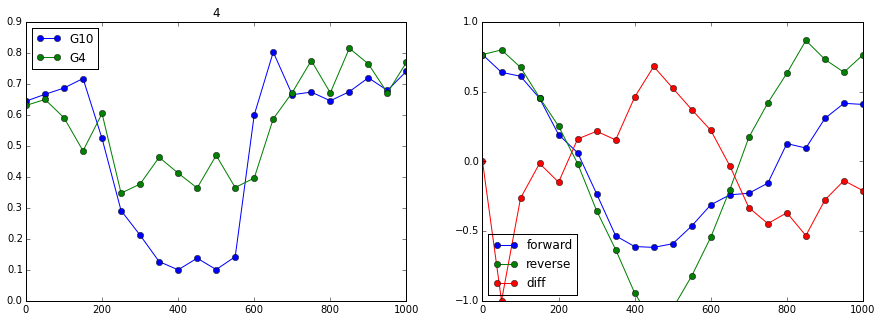

In [19]:
np.set_printoptions(linewidth=500)
def identify_lags(experiments, true_edges, swing_obj, perturb_idx=0, auto_len=10, p_thresh=0.05):
    for ee, experiment in enumerate(experiments):
        for parent, child in true_edges:
            data_df = pd.DataFrame()
            data_df['Parent'] = experiment[parent]
            data_df['Child'] = experiment[child]
            auto_parent = acf(data_df['Parent'])
            auto_child = acf(data_df['Child'])
            pval_parent = stats.linregress(data_df.index[:auto_len], auto_parent[:auto_len]).pvalue*len(swing_obj.gene_list)
            pval_child = stats.linregress(data_df.index[:auto_len], auto_child[:auto_len]).pvalue*len(swing_obj.gene_list)
            if pval_parent < p_thresh and pval_child < p_thresh:
                perturb_df = data_df.iloc[perturb_idx:]
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
                ax1.plot(perturb_df.index,  perturb_df['Parent'], 'o-', label=parent)
                ax1.plot(perturb_df.index,  perturb_df['Child'], 'o-', label=child)
                ax1.set_title(ee)
                ax1.legend(loc='best')
                ccf_forward = ccf(perturb_df['Parent'],  perturb_df['Child'])
                ccf_reverse = ccf( perturb_df['Child'], perturb_df['Parent'])
                diff = (ccf_forward-ccf_reverse)/range(1,len(perturb_df.index)+1)
                diff = diff/np.max(np.abs(diff))
                ax2.plot(perturb_df.index, ccf_forward, 'o-', c='c', label='forward')
                ax2.plot(perturb_df.index, ccf_reverse, 'o-', c='m', label='reverse')
                ax2.plot(perturb_df.index, diff, 'o-', c='k', label='diff')
                ax2.set_ylim([-1, 1])
                ax2.legend(loc='best')

identify_lags(experiments, true_edges, tdr, perturb_idx = )

    